In [1]:
import pandas as pd

all_postings = pd.read_csv('job_postings_unprocessed.csv')

print(all_postings.shape)
# remove NaN in pay_period
all_postings = all_postings.dropna(subset=['pay_period'])
print(all_postings.columns)
print(all_postings.shape)


(33246, 28)
Index(['job_id', 'company_id', 'title', 'description', 'max_salary',
       'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
       'location', 'applies', 'original_listed_time', 'remote_allowed',
       'views', 'job_posting_url', 'application_url', 'application_type',
       'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'scraped'],
      dtype='object')
(13352, 28)


Only 13352 out of 33246 rows in this dataset include salary information in 'pay_period' column

In [2]:
postings_salary = all_postings.loc[:, ['title','description', 'max_salary', 'med_salary', 'min_salary', 'pay_period']]
  
print(postings_salary.head())
# drop rows where max_salary, med_salary, and min_salary are all NaN
postings_salary = postings_salary.dropna(subset=['max_salary', 'med_salary', 'min_salary'], how='all')


                                          title  \
0                         Hearing Care Provider   
3                                          Cook   
4   Principal Cloud Security Architect (Remote)   
8                                    Dishwasher   
11             Insights Analyst - Auto Industry   

                                          description  max_salary  med_salary  \
0   Overview\n\nHearingLife is a national hearing ...         NaN     5250.00   
3   descriptionTitle\n\n Looking for a great oppor...         NaN       22.27   
4   Job Summary\nAt iHerb, we are on a mission to ...    275834.0         NaN   
8   descriptionTitle\n\n $2,000 Sign-on Bonus Guar...         NaN       19.30   
11  Who We Are\n\nEscalent is an award-winning dat...     64000.0         NaN   

    min_salary pay_period  
0          NaN    MONTHLY  
3          NaN     HOURLY  
4     205956.0     YEARLY  
8          NaN     HOURLY  
11     58000.0     YEARLY  


In [3]:
# combine title and description into one column "combined_text"
postings_salary['combined_text'] = postings_salary['title'] + ' ' + postings_salary['description']

### Calculate annual salary from median salary and pay period information

In [4]:

# average max and min salary to med_salary if med_salary is NaN and max_salary and min_salary are not NaN
postings_salary['med_salary'] = postings_salary['med_salary'].fillna((postings_salary['max_salary'] + postings_salary['min_salary']) / 2)

# drop entry where med_salary is 0
postings_salary = postings_salary[postings_salary['med_salary'] != 0]



In [5]:
postings_salary['pay_period'].unique()
print(postings_salary.shape)

(13350, 7)


Final processed dataset with full salary information has 13350 entries

In [6]:
# using med_salary and pay_period to average annual salary
def get_annual_salary(row):
    # assume 40 hours per week 
    if row['pay_period'] == 'HOURLY':
        return row['med_salary'] * 40 * 52
    elif row['pay_period'] == 'WEEKLY':
        return row['med_salary'] * 52
    elif row['pay_period'] == 'MONTHLY':
        return row['med_salary'] * 12
    elif row['pay_period'] == 'YEARLY':
        return row['med_salary']
    elif row['pay_period'] == 'ONCE':
        return row['med_salary']
    

postings_salary['annual_salary'] = postings_salary.apply(get_annual_salary, axis=1)




In [7]:
# describe the annual salary data
print(postings_salary['annual_salary'].describe())


count    1.335000e+04
mean     1.425794e+05
std      3.416309e+06
min      1.350000e+01
25%      5.200000e+04
50%      8.250000e+04
75%      1.238000e+05
max      3.432000e+08
Name: annual_salary, dtype: float64


### Group salary into 4 brackets: 0-50k, 50k-100k, 100k-150k, 150k+

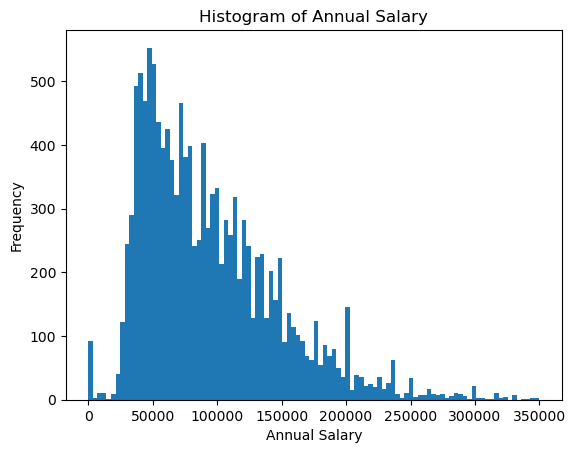

In [8]:
# historgram of annual salary
import matplotlib.pyplot as plt
plt.hist(postings_salary['annual_salary'], bins=100, range=(0, 350000))
plt.xlabel('Annual Salary')
plt.ylabel('Frequency')
plt.title('Histogram of Annual Salary')
plt.show()

In [9]:
# categorize salary into ranges
def categorize_salary(salary):
    if salary < 50000:
        return '0-50k'
    elif salary < 100000:
        return '50k-100k'
    elif salary < 150000:
        return '100k-150k'
    else:
        return '150k+'
    
postings_salary['salary_range'] = postings_salary['annual_salary'].apply(categorize_salary)


In [10]:

def categorize_salary_bin(salary_range):
    if salary_range == '0-50k':
        return 0
    elif salary_range == '50k-100k':
        return 1
    elif salary_range == '100k-150k':
        return 2
    else:
        return 3

postings_salary['salary_bin'] = postings_salary['salary_range'].apply(categorize_salary_bin)

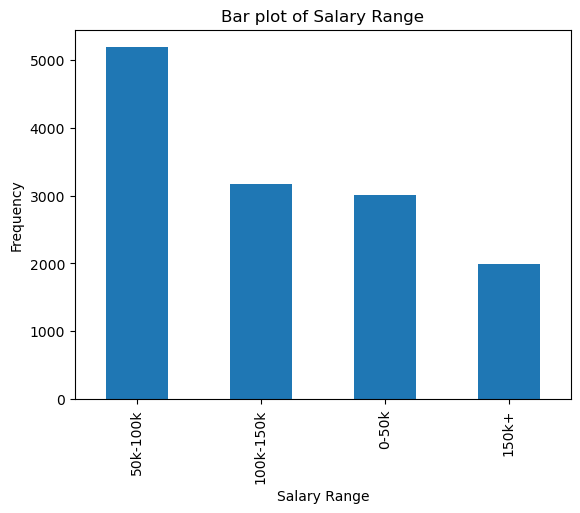

In [11]:
# print bar plot of each salary range
salary_range_counts = postings_salary['salary_range'].value_counts()
salary_range_counts.plot(kind='bar')
plt.xlabel('Salary Range')
plt.ylabel('Frequency')
plt.title('Bar plot of Salary Range')
plt.show()


The resulting histogram of salary bins show only a slight overrepresentation towards the lower end of the salary scale

In [12]:
header = ['combined_text', 'annual_salary', 'salary_range', 'salary_bin']
all_postings = postings_salary.loc[:, header]
print(all_postings.head())

                                        combined_text  annual_salary  \
0   Hearing Care Provider Overview\n\nHearingLife ...        63000.0   
3   Cook descriptionTitle\n\n Looking for a great ...        46321.6   
4   Principal Cloud Security Architect (Remote) Jo...       240895.0   
8   Dishwasher descriptionTitle\n\n $2,000 Sign-on...        40144.0   
11  Insights Analyst - Auto Industry Who We Are\n\...        61000.0   

   salary_range  salary_bin  
0      50k-100k           1  
3         0-50k           0  
4         150k+           3  
8         0-50k           0  
11     50k-100k           1  


### Tokenize, remove punctuations, emojis and stopwords

In [13]:
import nltk
import numpy as np
import pandas as pd
import argparse
import string
import re
from nltk.tokenize import word_tokenize

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

stemmer = nltk.stem.PorterStemmer()

In [14]:
# define initial stop words
closed_class_stop_words = ['a','the','an','and','or','but','about','above','after','along','amid','among',\
                           'as','at','by','for','from','in','into','like','minus','near','of','off','on',\
                           'onto','out','over','past','per','plus','since','till','to','under','until','up',\
                           'via','vs','with','that','can','cannot','could','may','might','must',\
                           'need','ought','shall','should','will','would','have','had','has','having','be',\
                           'is','am','are','was','were','being','been','get','gets','got','gotten',\
                           'getting','seem','seeming','seems','seemed',\
                           'enough', 'both', 'all', 'your' 'those', 'this', 'these', \
                           'their', 'the', 'that', 'some', 'our', 'no', 'neither', 'my',\
                           'its', 'his' 'her', 'every', 'either', 'each', 'any', 'another',\
                           'an', 'a', 'just', 'mere', 'such', 'merely' 'right', 'no', 'not',\
                           'only', 'sheer', 'even', 'especially', 'namely', 'as', 'more',\
                           'most', 'less' 'least', 'so', 'enough', 'too', 'pretty', 'quite',\
                           'rather', 'somewhat', 'sufficiently' 'same', 'different', 'such',\
                           'when', 'why', 'where', 'how', 'what', 'who', 'whom', 'which',\
                           'whether', 'why', 'whose', 'if', 'anybody', 'anyone', 'anyplace', \
                           'anything', 'anytime' 'anywhere', 'everybody', 'everyday',\
                           'everyone', 'everyplace', 'everything' 'everywhere', 'whatever',\
                           'whenever', 'whereever', 'whichever', 'whoever', 'whomever' 'he',\
                           'him', 'his', 'her', 'she', 'it', 'they', 'them', 'its', 'their','theirs',\
                           'you','your','yours','me','my','mine','I','we','us','much','and/or'
                           ]
stop_words = set([*nltk.corpus.stopwords.words('english'),
                *closed_class_stop_words])

### Create a Word Cloud to pick out non-insightful words in this specific dataset

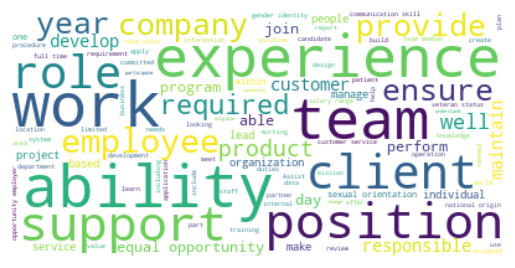

In [15]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

text = " ".join(description for description in all_postings['combined_text'])



wordcloud = WordCloud(stopwords = stop_words,max_font_size=50, max_words=100, background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



'company', 'ability', 'experience', 'year', 'work', 'position', 'employee' are common in every job postings. 
Words such as 'nation','origin','experi', 'opportun','sexual', 'orient', 'race', 'vetaran' are common in job postings' description as Equal Opportunity Employer and can be omitted

In [16]:
# add to stop words
stop_words.update(['company', 'ability', 'experience', 'year', 'job', 'hour',
                    'years', 'work', 'position', 'nation','origin', 
                    'opportunity','sexual', 'orient', 'race', 'vetaran', 'employees', 'role',
                    'including', 'required','join', 'able'])


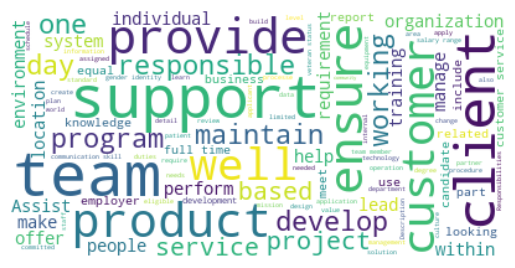

In [17]:
# word cloud after adding more stop words
wordcloud = WordCloud(stopwords = stop_words,max_font_size=50, max_words=100, background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [18]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F700-\U0001F77F"  
                           u"\U0001F780-\U0001F7FF"  
                           u"\U0001F800-\U0001F8FF"  
                           u"\U0001F900-\U0001F9FF"  
                           u"\U0001FA00-\U0001FA6F"  
                           u"\U0001FA70-\U0001FAFF"  
                           u"\U00002702-\U000027B0"  
                           u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [19]:
def preprocess_text(text):
    text_no_emojis = remove_emojis(text)
    tokens = word_tokenize(text_no_emojis)
    processed_tokens = [stemmer.stem(token.lower()) for token in tokens 
                        if token.lower() not in stop_words and token not in string.punctuation]
    return ' '.join(processed_tokens)

In [20]:
all_postings['processed_description'] = all_postings['combined_text'].apply(preprocess_text)

print(all_postings[['combined_text', 'processed_description']].head())


                                        combined_text  \
0   Hearing Care Provider Overview\n\nHearingLife ...   
3   Cook descriptionTitle\n\n Looking for a great ...   
4   Principal Cloud Security Architect (Remote) Jo...   
8   Dishwasher descriptionTitle\n\n $2,000 Sign-on...   
11  Insights Analyst - Auto Industry Who We Are\n\...   

                                processed_description  
0   hear care provid overview hearinglif nation he...  
3   cook descriptiontitl look great develop profes...  
4   princip cloud secur architect remot summari ih...  
8   dishwash descriptiontitl 2,000 sign-on bonu gu...  
11  insight analyst auto industri escal award-win ...  


In [21]:
# create processed_description csv
all_postings.to_csv('processed_description.csv', index=False)
